In [1]:
import os
import glob
import io
import collections
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats



In [2]:
def read_file(filename):
    # Joined path and filename using os.path.join() to make it more robust and platform-independent.
    path = os.path.join(filename)
    # Used read_table() instead of read_csv() as it is faster and more memory-efficient when reading tab-delimited files.
    df = pd.read_table(path, index_col=[0,1])
    return df

def get_failure(df):
    # check if total error is more than 10 kcal/mol and flag faliures
    df['acceptance_total_err'] = np.where(df['error(total)'] > 10, False, True)
    # check if contirubution of restraints in the complex is more 
    # than 2.5 times the median for all replicas and compunds of the condition
    df['acceptance_site_contr'] = np.where(df['ΔG(site,c+o+a+r)'] > 2.5 * df['ΔG(site,c+o+a+r)'].median(), True, False)
    # check which replica is failed
    df['acceptance_final'] = np.where(df['acceptance_site_contr'] & df['acceptance_total_err'], True, False)
    fail = df[df['acceptance_final'] == False]

def write_accept_reject(df, dir_name, out_name):
    # Initialize lists to store cmpnd and rep for acceptance_final as True and False
    cmpnd_list_acceptance_true = []
    rep_list_acceptance_true = []
    cmpnd_list_acceptance_false = []
    rep_list_acceptance_false = []
    
    # Loop through the rows of the dataframe and append cmpnd and rep to the appropriate lists
    for index, row in df.iterrows():
        # change the rep to match the directory names in repo
        rep_name = index[1]
        new_rep_name = rep_name[3] + '-' + rep_name
        
        cmpnd_name = index[0]
        if cmpnd_name == 'theophylline':
            new_cmpnd_name = '2-theophylline'
        elif cmpnd_name == '1_methylxanthine':
            new_cmpnd_name = '3-1_methylxanthine'
        elif cmpnd_name == '3_methylxanthine':
            new_cmpnd_name = '4-3_methylxanthine'
        elif cmpnd_name == 'hypoxanthine':
            new_cmpnd_name = '5-hypoxanthine'
        elif cmpnd_name == 'xanthine':
            new_cmpnd_name = '6-xanthine'
        elif cmpnd_name == 'caffeine':
            new_cmpnd_name = '7-caffeine'
        
        if row['acceptance_final'] == True:
            cmpnd_list_acceptance_true.append(new_cmpnd_name)
            rep_list_acceptance_true.append(new_rep_name)
        else:
            cmpnd_list_acceptance_false.append(new_cmpnd_name)
            rep_list_acceptance_false.append(new_rep_name)
    
    accept_file_name = './accept_reject_files/' + out_name + '_accept.txt'
    with open(accept_file_name, 'w') as file:
        for cmpnd, rep in zip(cmpnd_list_acceptance_true, rep_list_acceptance_true):
            entry = os.path.join(cmpnd,dir_name,rep)
            file.write(f"{entry}\t")
            
    reject_file_name = './accept_reject_files/' + out_name + '_reject.txt'
    with open(reject_file_name, 'w') as file:
        for cmpnd, rep in zip(cmpnd_list_acceptance_false, rep_list_acceptance_false):
            entry = os.path.join(cmpnd,dir_name,rep)
            file.write(f"{entry}\t")

# This function takes in a pandas DataFrame, `df`, and an offset value as input
def get_mean_std(df, offset):
    # A list of compound names to extract
    cmpnd_list = [ 'theophylline', '3_methylxanthine', 'xanthine', '1_methylxanthine', 'hypoxanthine', 'caffeine' ]
    # Extract a subset of the DataFrame where the 'acceptance_final' column is True and only include the 'ΔG(total)' column
    df2 = df.loc[df['acceptance_final'] == True, 'ΔG(total)']
    # Create empty arrays to store the mean and standard deviation of each compound's measurements
    mean_ = np.zeros(6)
    std_ = np.zeros(6)
    # iterate through 6 compunds
    for i in range(6):
        # chekc if we have 3 accepted replicas and print the Error message otherwise
        if df2.loc[cmpnd_list[i]].size != 3:
            print('Error, number of accpeted reps is not three in: ', cmpnd_list[i])
            mean_[i] = df2.loc[cmpnd_list[i]].mean()
            std_[i] = df2.loc[cmpnd_list[i]].std()
        else:
            mean_[i] = df2.loc[cmpnd_list[i]].mean()
            std_[i] = df2.loc[cmpnd_list[i]].std()

    # add the offset value to be added to all the averaged values (non-zero only for bb colvar restrains)
    mean_ += offset    
    return mean_, std_
    
# =============================================================================
# STATS FUNCTIONS
# =============================================================================

# def r2(data):
#     x, y = data.T
#     slope, intercept, r_value, p_value, stderr = scipy.stats.linregress(x, y)
#     return r_value**2


# def slope(data):
#     x, y = data.T
#     slope, intercept, r_value, p_value, stderr = scipy.stats.linregress(x, y)
#     return slope


# def me(data):
#     x, y = data.T
#     error = np.array(x) - np.array(y)
#     return error.mean()


def mae(data):
    x, y = data.T
    error = np.abs(np.array(x) - np.array(y))
    return error.mean()


def rmse(data):
    x, y = data.T
    error = np.array(x) - np.array(y)
    rmse = np.sqrt((error**2).mean())
    return rmse

# def pearsons_r(data):
#     x, y = data.T
#     slope, intercept, r_value, p_value, stderr = scipy.stats.linregress(x, y)
#     return r_value

def pearsons_r(data):
    x, y = data.T
    pearsons_r, p_value = scipy.stats.pearsonr(x, y)
    return pearsons_r


def spearmans_rho(data):
    x, y = data.T
    spearmans_r, p_value = scipy.stats.spearmanr(x, y)
    return spearmans_r

def kendall_tau(data):
    x, y = data.T
    correlation, p_value = scipy.stats.kendalltau(x, y)
    return correlation


def compute_bootstrap_statistics(samples, stats_funcs, percentile=0.95, n_bootstrap_samples=1000):
    """Compute bootstrap confidence interval for the given statistics functions."""
    # Handle case where only a single function is passed.
    #print("SAMPLES:\n", samples)

    try:
        len(stats_funcs)
    except TypeError:
        stats_funcs = [stats_funcs]

    # Compute mean statistics.
    statistics = [stats_func(samples) for stats_func in stats_funcs]

    # Generate bootstrap statistics.
    bootstrap_samples_statistics = np.zeros((len(statistics), n_bootstrap_samples))
    for bootstrap_sample_idx in range(n_bootstrap_samples):
        samples_indices = np.random.randint(low=0, high=len(samples), size=len(samples))
        for stats_func_idx, stats_func in enumerate(stats_funcs):
            bootstrap_samples_statistics[stats_func_idx][bootstrap_sample_idx] = stats_func(samples[samples_indices])

    # Compute confidence intervals.
    percentile_index = int(np.floor(n_bootstrap_samples * (1 - percentile) / 2)) - 1
    bootstrap_statistics = []
    for stats_func_idx, samples_statistics in enumerate(bootstrap_samples_statistics):
        samples_statistics.sort()
        stat_lower_percentile = samples_statistics[percentile_index]
        stat_higher_percentile = samples_statistics[-percentile_index+1]
        confidence_interval = (stat_lower_percentile, stat_higher_percentile)
        bootstrap_statistics.append([statistics[stats_func_idx], confidence_interval, samples_statistics])

    return bootstrap_statistics

# =============================================================================
# PLOTTING FUNCTIONS
# =============================================================================

def barplot_with_CI_errorbars(df, x_label, y_label, y_lower_label, y_upper_label, figsize=False):
    """Creates bar plot of a given dataframe with asymmetric error bars for y axis.

    Args:
        df: Pandas Dataframe that should have columns with columnnames specified in other arguments.
        x_label: str, column name of x axis categories
        y_label: str, column name of y axis values
        y_lower_label: str, column name of lower error values of y axis
        y_upper_label: str, column name of upper error values of y axis
        figsize: tuple, size in inches. Default value is False.

    """
    # Column names for new columns for delta y_err which is calculated as | y_err - y |
    delta_lower_yerr_label = "$\Delta$" + y_lower_label
    delta_upper_yerr_label = "$\Delta$" + y_upper_label
    data = df  # Pandas DataFrame
    data.loc[:,delta_lower_yerr_label] = data.loc[:,y_label] - data.loc[:,y_lower_label]
    data.loc[:,delta_upper_yerr_label] = data.loc[:,y_upper_label] - data.loc[:,y_label]

    # Color
    current_palette = sns.color_palette()
    sns_color = current_palette[2]

    # Plot style
    plt.close()
    plt.style.use(["seaborn-talk", "seaborn-whitegrid"])
    plt.rcParams['axes.labelsize'] = 20 # 18
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 18 #16
    plt.rcParams['legend.fontsize'] = 16
    plt.rcParams['legend.handlelength'] = 2
    #plt.tight_layout()

    # If figsize is specified
    if figsize != False:
        plt.figure(figsize=figsize)

    # Plot
    #x = range(len(data[y_label]))
    x = data[x_label]  # Use the actual Method ID (categorical)
    y = data[y_label]
    plt.bar(x, y)
    #plt.xticks(x, data[x_label], rotation=90)
    plt.errorbar(x, y, yerr=(data[delta_lower_yerr_label], data[delta_upper_yerr_label]),
                 fmt="none", ecolor=sns_color, capsize=3, capthick=True)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

In [3]:
# Define output directory path
DIRECTORY_PATH = './performance_with_CI/'
FILE_BASE_NAME = 'performance_stats_with_CI'

In [4]:
# Collect the statistics records for the DataFrames.
statistics_csv = []
statistics_latex = []
statistics_plot = []

#stats_funcs = collections.OrderedDict([ ('R-squared', r2), ['MAE', mae] ])
# Configuration: statistics to compute.
stats_funcs = collections.OrderedDict([
    ('MAE', mae),
    ('RMSE', rmse),
    ("pearsons_r", pearsons_r),
    ('kendall_tau', kendall_tau),
    ("spearmans_rho", spearmans_rho),
])
ordering_functions = {
    'kendall_tau': lambda x: -x
}
latex_header_conversions = {
    'MAE': 'MAE',
    'RMSE': 'RMSE',
    'pearsons_r': "Pearson's r",
    'kendall_tau': '$\\tau$',
    'spearmans_rho': "Spearman's Rho"
}

stats_names = list(stats_funcs.keys())
ci_suffixes = ('', '_lower_bound', '_upper_bound')

# Create lists of stats functions to pass to compute_bootstrap_statistics.
stats_funcs_names, stats_funcs = zip(*stats_funcs.items())

In [5]:
# Create experimental vs predicted value dataframe
# First column is experimental value and second column is predicted value and each row is a different system

###########    ['theo','mth3','xan','mth1','hyp','caf'])
exp_binding_free_energy_values = np.array([-8.86, -7.77, -6.91, -6.88, -5.88, -3.35])

In [6]:
file_dict = {
    #                                  salt cond.   # Mg   water.  lig ff    windows         BB rest. offset         title                     Dir name                       Condition ID                    
    '55_NaCl_0Mg_TP3_GAF_40_1ns_unres':['55 NaCl',     '0', 'TIP3P', 'GAFF2', '40 win, 1 ns/win', 'No', 0,   "\n55 mM NaCl & 0 Mg$^{2+}$",   '4-55NaCl/1-40winCmplx_30winLig', '1'],
    '55_NaCl_2Mg_TP3_GAF_40_1ns_unres':['55 NaCl',     '2', 'TIP3P', 'GAFF2', '40 win, 1 ns/win', 'No', 0,   "\n55 mM NaCl & 2 Mg$^{2+}$",   '3-55NaCl_Mg/1-40winCmplx_30winLig', '2'],
    '55_NaCl_3Mg_TP3_GAF_40_1ns_unres':['55 NaCl',     '3', 'TIP3P', 'GAFF2', '40 win, 1 ns/win', 'No', 0,   "\n55 mM NaCl & 3 Mg$^{2+}$",   '1-55NaCl_3Mg/1-40winCmplx_30winLig', '3'],
    #
    '55_NaCl_0Mg_TP3_GAF_40_1ns_BBres':['55 NaCl',     '0', 'TIP3P', 'GAFF2', '40 win, 1 ns/win','Yes', 9.4, "55 mM NaCl & 0 Mg$^{2+}$\nw/ backbone restraints contribution", '9-5NaCl_bb_colvar/1-40winCmplx_30winLig', '4'],
    '55_NaCl_2Mg_TP3_GAF_40_1ns_BBres':['55 NaCl',     '2', 'TIP3P', 'GAFF2', '40 win, 1 ns/win','Yes', 9.7, "55 mM NaCl & 2 Mg$^{2+}$\nw/ backbone restraints contribution", '8-5NaCl_Mg_bb_colvar/1-40winCmplx_30winLig', '5'],
    '55_NaCl_3Mg_TP3_GAF_40_1ns_BBres':['55 NaCl',     '3', 'TIP3P', 'GAFF2', '40 win, 1 ns/win','Yes', 10,  "55 mM NaCl & 3 Mg$^{2+}$\nw/ backbone restraints contribution", '4-55NaCl_3Mg_bb_colvar/1-40winCmplx_30winLig', '6'],
    #
    '55_NaCl_2Mg_OPC_GAF_40_1ns_unres':['55 NaCl',     '2', 'OPC'  , 'GAFF2', '40 win, 1 ns/win', 'No', 0,   "55 mM NaCl & 2 Mg$^{2+}$\nw/ OPC water", '3-55NaCl_Mg/6-opc_40winCmplx_30winLig', '7'],
    '55_NaCl_2Mg_TP3_OFF_40_1ns_unres':['55 NaCl',     '2', 'TIP3P', 'OpenFF','40 win, 1 ns/win', 'No', 0,   "55 mM NaCl & 2 Mg$^{2+}$\nw/ OpenFF", '3-55NaCl_Mg/2-OpenFF_40winCmplx_30winLig', '8'], # Latest addition   
    '55_NaCl_3Mg_TP3_OFF_40_1ns_unres':['55 NaCl',     '3', 'TIP3P', 'OpenFF','40 win, 1 ns/win', 'No', 0,   "55 mM NaCl & 3 Mg$^{2+}$\nw/ OpenFF", '1-55NaCl_3Mg/2-OpenFF_40winCmplx_30winLig', '9'],
    #
    '55_KCl_2Mg_TP3_GAF_40_1ns_unres': ['55 KCl',      '2', 'TIP3P', 'GAFF2', '40 win, 1 ns/win', 'No', 0,   "\n55 mM KCl & 2 Mg$^{2+}$",   '10-55KCl_Mg/1-40winCmplx_30winLig', '10'],
    '55_KCl_3Mg_TP3_GAF_40_1ns_unres': ['55 KCl',      '3', 'TIP3P', 'GAFF2', '40 win, 1 ns/win', 'No', 0,   "\n55 mM KCl & 3 Mg$^{2+}$",   '3-55KCl_3Mg/1-40winCmplx_30winLig', '11'],
    '150_KCl_2Mg_TP3_GAF_40_1ns_unres':['150 KCl',     '3', 'TIP3P', 'GAFF2', '40 win, 1 ns/win', 'No', 0,   "\n150 mM KCl & 3 Mg$^{2+}$",   '10-55KCl_Mg/1-40winCmplx_30winLig', '12'],
    '0_NaCl_3Mg_TP3_GAF_40_1ns_unres': ['Neutralized', '3', 'TIP3P', 'GAFF2', '40 win, 1 ns/win', 'No', 0,   "\nNeutralized & 3 Mg$^{2+}$", '2-Neut_3Mg/1-40winCmplx_30winLig', '13'],
    #
    '55_NaCl_2Mg_TP3_GAF_80_1ns_unres':['55 NaCl',     '2', 'TIP3P', 'GAFF2', '80 win, 1 ns/win','No', 0,  "55 mM NaCl & 2 Mg$^{2+}$\n80 win, 1 ns/win", '3-55NaCl_Mg/2-80winCmplx', '14'],
    '55_NaCl_2Mg_TP3_GAF_40_2ns_unres':['55 NaCl',     '2', 'TIP3P', 'GAFF2', '40 win, 2 ns/win','No', 0,  "55 mM NaCl & 2 Mg$^{2+}$\n40 win, 2 ns/win", '3-55NaCl_Mg/5-40winCmplx_2ns', '15'],
    '55_NaCl_2Mg_TP3_GAF_80_1ns_BBres':['55 NaCl',     '2', 'TIP3P', 'GAFF2', '80 win, 1 ns/win','Yes', 9.7,  "55 mM NaCl & 2 Mg$^{2+}$\nw/ backbone restraints contribution\n80 win, 1 ns/win", '8-5NaCl_Mg_bb_colvar/4-80winCmplx', '16'],
    '55_NaCl_2Mg_TP3_GAF_40_2ns_BBres':['55 NaCl',     '2', 'TIP3P', 'GAFF2', '40 win, 2 ns/win','Yes', 9.7,  "55 mM NaCl & 2 Mg$^{2+}$\nw/ backbone restraints contribution\n40 win, 2 ns/win", '8-5NaCl_Mg_bb_colvar/5-40winCmplx_2ns', '17'],
    '55_NaCl_0Mg_TP3_GAF_80_1ns_BBres':['55 NaCl',     '0', 'TIP3P', 'GAFF2', '80 win, 1 ns/win','Yes', 9.4,  "55 mM NaCl & 0 Mg$^{2+}$\nw/ backbone restraints contribution\n80 win, 1 ns/win", '9-5NaCl_bb_colvar/4-80winCmplx', '18'],
    '55_NaCl_0Mg_TP3_GAF_40_2ns_BBres':['55 NaCl',     '0', 'TIP3P', 'GAFF2', '40 win, 2 ns/win','Yes', 9.4,  "55 mM NaCl & 0 Mg$^{2+}$\nw/ backbone restraints contribution\n40 win, 2 ns/win", '9-5NaCl_bb_colvar/3-40winCmplx_2ns', '19'],
    #
    'MMGBSA_for_RNA_salt_Mg'            :['55 NaCl',     '2', 'TIP3P', 'GAFF2', 'MM-GBSA','No', 0,  "55 mM NaCl & 2 Mg$^{2+}$\n MM-GBSA", 'MMGBSA', '20'],
    'MMGBSA_for_RNA_salt'               :['55 NaCl',     '0', 'TIP3P', 'GAFF2', 'MM-GBSA','No', 0,  "55 mM NaCl & 0 Mg$^{2+}$\n MM-GBSA", 'MMGBSA', '21'],
}

In [7]:
# Iterate through conditions
for key in file_dict.keys():
    if file_dict[key][-2] != 'MMGBSA':
        path = os.path.join('./BFE_failed_rep/',key + '.txt')
    elif file_dict[key][-2] == 'MMGBSA':
        path = os.path.join('./MMGBSA/',key + '.txt')
    
    cond_name = key
    print(cond_name)
    
    cond_id = file_dict[key][9]
    print(cond_id)
    
    df = read_file(path)
    
    if file_dict[key][-2] != 'MMGBSA':
        get_failure(df)
        # Select accepted replicates only
        #df_accept = df[df['acceptance_final'] == True]
        #display(df_accept)
        write_accept_reject(df, file_dict[key][8],key)
    
        # Calculate mean predicted values and standard deviation
        mean, std = get_mean_std(df, file_dict[key][6]) # second number is offset value (non-zero only for colvar bb rst.)
    elif file_dict[key][-2] == 'MMGBSA':
        # Get compound names from file
        compound_names = []
        for tuple in df.index:
            # Capture names only for 1st replicate
            i = tuple[1]
            if i == 1:
                compound_names.append(tuple[0])
        print(compound_names)
    
        # Get mean and std values for MMGBSA predictions
        mean = np.zeros(6)
        std = np.zeros(6)
        for i,cmp in enumerate(compound_names):
            mean[i] = df.loc[cmp]['_G (MMGBSA)'].mean()
            std[i] = df.loc[cmp]['_G (MMGBSA)'].std()

    print("Predicted results (mean):\n", mean)
    print("Predicted results (std):\n",std)

    # Create horizontal stacking of predicted and experimental values
    data = np.vstack((np.array(mean), exp_binding_free_energy_values))
    print("\nPredicted vs experimental values for condition {}:".format(cond_id))
    print(data.shape)
    display(data)

    # We will bootstrap over systems with replacement 1000 times.
    data = pd.DataFrame(data).transpose()
    samples = data.to_numpy()
    bootstrap_statistics = compute_bootstrap_statistics(samples, stats_funcs, n_bootstrap_samples=1000) 

    # Return statistics as dict preserving the order.
    bootstrap_statistics_dict = collections.OrderedDict((stats_funcs_names[i], bootstrap_statistics[i]) for i in range(len(stats_funcs)))
    print("bootstrap_statistics_dict:\n", bootstrap_statistics_dict)

    # Organize data to construct CSV and PDF versions of statistics tables
    record_csv = {}
    record_latex = {}
    for stats_name, (stats, (lower_bound, upper_bound), bootstrap_samples) in bootstrap_statistics_dict.items():
        # For CSV and JSON we put confidence interval in separate columns.
        for suffix, info in zip(ci_suffixes, [stats, lower_bound, upper_bound]):
            record_csv[stats_name + suffix] = info

        # For the PDF, print bootstrap CI in the same column.
        stats_name_latex = latex_header_conversions.get(stats_name, stats_name)
        record_latex[stats_name_latex] = '{:.2f} [{:.2f}, {:.2f}]'.format(stats, lower_bound, upper_bound)

        # For the violin plot, we need all the bootstrap statistics series.
        for bootstrap_sample in bootstrap_samples:
            statistics_plot.append(dict(ID=cond_id, name=cond_name, statistics=stats_name_latex, value=bootstrap_sample))

    statistics_csv.append({'ID': cond_id, 'name': cond_name, **record_csv})
    escaped_name = cond_name.replace('_', '\_')
    statistics_latex.append({'ID': cond_id, 'name': escaped_name, **record_latex})
    

55_NaCl_0Mg_TP3_GAF_40_1ns_unres
1
Predicted results (mean):
 [ -8.86468311 -10.17995765  -7.05708094  -8.92615367  -2.20755616
  -3.60227173]
Predicted results (std):
 [3.57432172 2.75868451 5.69031628 2.42270137 0.56347642 3.69907004]

Predicted vs experimental values for condition 1:
(2, 6)


array([[ -8.86468311, -10.17995765,  -7.05708094,  -8.92615367,
         -2.20755616,  -3.60227173],
       [ -8.86      ,  -7.77      ,  -6.91      ,  -6.88      ,
         -5.88      ,  -3.35      ]])

bootstrap_statistics_dict:
 OrderedDict([('MAE', [1.4220984889444666, (0.45119071606477784, 2.5190536589974886), array([0.06968085, 0.08721265, 0.11094562, 0.11094562, 0.1171468 ,
       0.1171468 , 0.1346786 , 0.15841157, 0.16974219, 0.17594337,
       0.18214454, 0.36866118, 0.36866118, 0.38619297, 0.39239415,
       0.41612712, 0.41612712, 0.41612712, 0.42745774, 0.42929517,
       0.42929517, 0.43365892, 0.43365892, 0.43986009, 0.45119072,
       0.45119072, 0.45119072, 0.45302814, 0.45739189, 0.45739189,
       0.45739189, 0.45739189, 0.45739189, 0.45739189, 0.46872251,
       0.47055994, 0.47055994, 0.47055994, 0.47055994, 0.47492369,
       0.47492369, 0.47492369, 0.47492369, 0.47492369, 0.47492369,
       0.47492369, 0.47492369, 0.47492369, 0.47492369, 0.47676112,
       0.47676112, 0.47676112, 0.47676112, 0.48112486, 0.49245549,
       0.49245549, 0.49245549, 0.49245549, 0.49245549, 0.49429291,
       0.49429291, 0.49429291, 0.49429291, 0.49865666, 0.50049409,
       0.5118247

array([[-11.27871825, -10.1075203 ,  -8.87380793, -10.30354989,
         -6.34852274,  -5.91183156],
       [ -8.86      ,  -7.77      ,  -6.91      ,  -6.88      ,
         -5.88      ,  -3.35      ]])

bootstrap_statistics_dict:
 OrderedDict([('MAE', [2.1956584458477546, (1.4594556614132312, 2.855634911347575), array([0.79355533, 1.06662174, 1.06662174, 1.14244013, 1.21024146,
       1.28605985, 1.28605985, 1.28605985, 1.29198372, 1.29198372,
       1.30991207, 1.31583594, 1.34073612, 1.34073612, 1.36780211,
       1.37812133, 1.37812133, 1.37812133, 1.37812133, 1.39165433,
       1.39165433, 1.44040673, 1.45945566, 1.45945566, 1.45945566,
       1.45945566, 1.47779194, 1.47779194, 1.49132493, 1.49132493,
       1.49132493, 1.49132493, 1.52174106, 1.52766493, 1.52766493,
       1.53527405, 1.53527405, 1.54119792, 1.55912627, 1.55912627,
       1.56505014, 1.58402645, 1.58995032, 1.58995032, 1.58995032,
       1.59755944, 1.59755944, 1.60348331, 1.60348331, 1.60348331,
       1.60348331, 1.61701631, 1.62141166, 1.62141166, 1.62141166,
       1.62141166, 1.62733553, 1.62733553, 1.62733553, 1.63494465,
       1.63494465, 1.63494465, 1.64086853, 1.64086853, 1.64086853,
       1.65223572,

array([[-12.00438307, -10.34292073,  -8.66825199, -10.0601371 ,
         -3.40886098,  -8.06108678],
       [ -8.86      ,  -7.77      ,  -6.91      ,  -6.88      ,
         -5.88      ,  -3.35      ]])

bootstrap_statistics_dict:
 OrderedDict([('MAE', [2.9729864494848166, (2.3391101881048804, 3.8155275862824083), array([2.10808834, 2.10808834, 2.11404735, 2.12505196, 2.13101096,
       2.13101096, 2.13165912, 2.14862274, 2.14862274, 2.22625469,
       2.22690285, 2.22690285, 2.23286185, 2.24386646, 2.24386646,
       2.24386646, 2.24386646, 2.24982547, 2.24982547, 2.26678909,
       2.26678909, 2.26678909, 2.28440086, 2.28440086, 2.33911019,
       2.33911019, 2.33911019, 2.34506919, 2.34506919, 2.34571735,
       2.34571735, 2.34571735, 2.3510282 , 2.3510282 , 2.3510282 ,
       2.35167636, 2.35607381, 2.36203281, 2.36203281, 2.36268097,
       2.36268097, 2.36268097, 2.36268097, 2.36268097, 2.36268097,
       2.36268097, 2.36268097, 2.36268097, 2.36268097, 2.36799182,
       2.36863998, 2.36863998, 2.36863998, 2.36863998, 2.36920563,
       2.36928813, 2.37964459, 2.37964459, 2.37964459, 2.37964459,
       2.37964459, 2.37964459, 2.37964459, 2.38560359, 2.38560359,
       2.38560359

array([[-11.91698359,  -9.60217267,  -7.25512   ,  -9.40574624,
         -3.96809253,  -7.11336252],
       [ -8.86      ,  -7.77      ,  -6.91      ,  -6.88      ,
         -5.88      ,  -3.35      ]])

bootstrap_statistics_dict:
 OrderedDict([('MAE', [2.2392154152218287, (1.306070620729083, 3.0883080786537547), array([0.60625124, 0.60625124, 0.85409336, 0.91482708, 0.96968895,
       0.96968895, 1.04493937, 1.1152246 , 1.1152246 , 1.16053497,
       1.1626692 , 1.17595833, 1.17595833, 1.20424193, 1.21753106,
       1.21753106, 1.21753106, 1.21753106, 1.21753106, 1.21753106,
       1.2308202 , 1.24907453, 1.29278149, 1.29278149, 1.30607062,
       1.30607062, 1.30607062, 1.31935975, 1.31983752, 1.31983752,
       1.33312666, 1.33312666, 1.33312666, 1.33312666, 1.33312666,
       1.33312666, 1.33312666, 1.33312666, 1.34977758, 1.34977758,
       1.40837708, 1.40837708, 1.42166622, 1.42166622, 1.42166622,
       1.42166622, 1.42380044, 1.42380044, 1.45208404, 1.46537318,
       1.46537318, 1.46537318, 1.46537318, 1.46537318, 1.47866231,
       1.47866231, 1.48453417, 1.49195144, 1.49691664, 1.49691664,
       1.49691664, 1.49691664, 1.5261069 , 1.5261069 , 1.5261069 ,
       1.5261069 ,

array([[-12.70709879, -10.12363859,  -7.71058238, -10.06067651,
         -4.64685588,  -7.62835398],
       [ -8.86      ,  -7.77      ,  -6.91      ,  -6.88      ,
         -5.88      ,  -3.35      ]])

bootstrap_statistics_dict:
 OrderedDict([('MAE', [2.615582395538664, (1.5939470895182912, 3.626849514403157), array([0.94476962, 1.01686325, 1.19726473, 1.20361233, 1.27570595,
       1.34145198, 1.45610744, 1.46245503, 1.46245503, 1.46245503,
       1.46245503, 1.48563923, 1.52439822, 1.52439822, 1.52439822,
       1.52439822, 1.52439822, 1.52461598, 1.52461598, 1.52820106,
       1.52820106, 1.52820106, 1.53454865, 1.56717782, 1.59394709,
       1.59649185, 1.59649185, 1.60029468, 1.60029468, 1.63905368,
       1.63927144, 1.64920411, 1.66604071, 1.66604071, 1.66604071,
       1.67238831, 1.67238831, 1.67238831, 1.70501747, 1.7111473 ,
       1.7111473 , 1.7111473 , 1.7111473 , 1.7111473 , 1.7111473 ,
       1.71136506, 1.71495014, 1.72129773, 1.73813434, 1.73813434,
       1.73813434, 1.73813434, 1.77689333, 1.77711109, 1.77711109,
       1.77711109, 1.77711109, 1.77711109, 1.77711109, 1.78324093,
       1.78324093, 1.78324093, 1.78324093, 1.78345869, 1.78345869,
       1.78704376, 

array([[-10.15237902, -10.00727858,  -8.285507  , -11.81051093,
         -4.82241583,  -8.63576579],
       [ -8.86      ,  -7.77      ,  -6.91      ,  -6.88      ,
         -5.88      ,  -3.35      ]])

bootstrap_statistics_dict:
 OrderedDict([('MAE', [2.6965042470582183, (1.3993066570446577, 4.112120124001501), array([1.13584912, 1.18883626, 1.21411407, 1.2418234 , 1.2418234 ,
       1.25567806, 1.28095587, 1.28095587, 1.29333238, 1.33246486,
       1.33246486, 1.33246486, 1.34631952, 1.34631952, 1.34779767,
       1.37159733, 1.38545199, 1.38545199, 1.38545199, 1.39930666,
       1.39930666, 1.39930666, 1.39930666, 1.39930666, 1.39930666,
       1.39930666, 1.39930666, 1.41316132, 1.42458447, 1.42458447,
       1.42458447, 1.42458447, 1.42458447, 1.45229379, 1.45229379,
       1.45229379, 1.45229379, 1.46371694, 1.46371694, 1.46371694,
       1.46371694, 1.4775716 , 1.4775716 , 1.48994812, 1.50380278,
       1.50380278, 1.50380278, 1.50528093, 1.50528093, 1.52908059,
       1.52908059, 1.52908059, 1.52908059, 1.54293525, 1.54293525,
       1.54293525, 1.54293525, 1.54293525, 1.54293525, 1.55678992,
       1.55678992, 1.56821306, 1.56821306, 1.58206773, 1.58206773,
       1.58206773,

array([[ -7.9584896 ,  -9.71409259,  -7.88615937, -11.35455431,
         -5.15716718,  -7.84170536],
       [ -8.86      ,  -7.77      ,  -6.91      ,  -6.88      ,
         -5.88      ,  -3.35      ]])

/Users/misik/opt/anaconda3/envs/fe_analysis/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/misik/opt/anaconda3/envs/fe_analysis/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


bootstrap_statistics_dict:
 OrderedDict([('MAE', [2.2518091448615354, (1.0281564034651594, 3.475461886257912), array([0.76505392, 0.78239202, 0.79483351, 0.79483351, 0.82461311,
       0.8370546 , 0.8370546 , 0.8370546 , 0.8370546 , 0.85439271,
       0.8792757 , 0.8792757 , 0.8841723 , 0.8966138 , 0.8966138 ,
       0.90905529, 0.90905529, 0.93883489, 0.98593531, 0.98593531,
       0.99837681, 1.0108183 , 1.01571491, 1.0281564 , 1.0281564 ,
       1.0281564 , 1.0281564 , 1.0405979 , 1.0405979 , 1.0405979 ,
       1.0405979 , 1.0405979 , 1.04549451, 1.057936  , 1.057936  ,
       1.057936  , 1.0703775 , 1.0703775 , 1.0703775 , 1.0703775 ,
       1.0703775 , 1.08281899, 1.08281899, 1.08281899, 1.08281899,
       1.08281899, 1.08281899, 1.0877156 , 1.09526049, 1.12991941,
       1.15969901, 1.1721405 , 1.18947861, 1.18947861, 1.18947861,
       1.2019201 , 1.2019201 , 1.2019201 , 1.2019201 , 1.2019201 ,
       1.2019201 , 1.2143616 , 1.2192582 , 1.2192582 , 1.2316997 ,
       1.2316997 ,

array([[-12.04741354,  -9.28519027,  -9.73887146,  -5.75527074,
         -7.00547311,  -8.25593432],
       [ -8.86      ,  -7.77      ,  -6.91      ,  -6.88      ,
         -5.88      ,  -3.35      ]])

bootstrap_statistics_dict:
 OrderedDict([('MAE', [2.447935324758028, (1.468633944503302, 3.6484560249522846), array([1.12510118, 1.18993007, 1.19005404, 1.19017802, 1.19017802,
       1.19017802, 1.19017802, 1.19017802, 1.2550069 , 1.25513088,
       1.25513088, 1.25525485, 1.31995976, 1.32008374, 1.32020771,
       1.32033169, 1.3850366 , 1.40900091, 1.40900091, 1.40900091,
       1.40912488, 1.40912488, 1.40924886, 1.46850997, 1.46863394,
       1.46875792, 1.46888189, 1.46888189, 1.46888189, 1.46888189,
       1.46900587, 1.46900587, 1.47407774, 1.47407774, 1.47407774,
       1.47420172, 1.47420172, 1.47432569, 1.47432569, 1.53371078,
       1.53371078, 1.53383475, 1.53383475, 1.53383475, 1.53383475,
       1.53383475, 1.53383475, 1.53383475, 1.53383475, 1.53395873,
       1.53395873, 1.53890663, 1.53890663, 1.5390306 , 1.5390306 ,
       1.5390306 , 1.53915458, 1.53915458, 1.53915458, 1.53915458,
       1.53915458, 1.59866364, 1.59878761, 1.59878761, 1.59891159,
       1.59891159, 

array([[-11.42669937,  -7.37562714,  -9.27680425, -11.77470739,
         -7.24451707,  -5.92873467],
       [ -8.86      ,  -7.77      ,  -6.91      ,  -6.88      ,
         -5.88      ,  -3.35      ]])

bootstrap_statistics_dict:
 OrderedDict([('MAE', [2.3609726029945404, (1.282178284513775, 3.5303396657250787), array([1.04113567, 1.04113567, 1.04649283, 1.04649283, 1.05184999,
       1.08516585, 1.08717173, 1.08717173, 1.1184817 , 1.1184817 ,
       1.12048758, 1.20818353, 1.20818353, 1.20818353, 1.21354069,
       1.24149939, 1.24149939, 1.24149939, 1.24685655, 1.24685655,
       1.24886243, 1.28217828, 1.28217828, 1.28217828, 1.28217828,
       1.28418417, 1.28418417, 1.37523139, 1.37523139, 1.37523139,
       1.37523139, 1.37523139, 1.40319009, 1.40319009, 1.40519597,
       1.40854725, 1.40854725, 1.40854725, 1.41055313, 1.41055313,
       1.41055313, 1.41055313, 1.41055313, 1.41390441, 1.41390441,
       1.41591029, 1.4418631 , 1.4418631 , 1.44386899, 1.44386899,
       1.44386899, 1.44386899, 1.44386899, 1.44587487, 1.44587487,
       1.44722026, 1.44922615, 1.44922615, 1.46781002, 1.46781002,
       1.47316718, 1.47316718, 1.48454788, 1.48454788, 1.48655377,
       1.50848892,

array([[ -9.83538726,  -7.67455325,  -7.69454993, -10.08667755,
         -4.12118888,  -8.01884318],
       [ -8.86      ,  -7.77      ,  -6.91      ,  -6.88      ,
         -5.88      ,  -3.35      ]])

bootstrap_statistics_dict:
 OrderedDict([('MAE', [1.9149526340790715, (0.7172257388759982, 3.259228236044122), array([0.32514781, 0.35695403, 0.35695403, 0.35695403, 0.37267415,
       0.38876026, 0.47180456, 0.53541701, 0.53541701, 0.60237521,
       0.61398522, 0.63418143, 0.63418143, 0.64990154, 0.64990154,
       0.65026754, 0.65026754, 0.66598765, 0.66598765, 0.66598765,
       0.66598765, 0.68207376, 0.68207376, 0.71722574, 0.71722574,
       0.72883575, 0.73331185, 0.74903196, 0.74903196, 0.74903196,
       0.76064197, 0.76475207, 0.76511807, 0.78083818, 0.78083818,
       0.78083818, 0.78083818, 0.78083818, 0.79655829, 0.79692429,
       0.79692429, 0.8126444 , 0.8126444 , 0.83207627, 0.86388249,
       0.8754925 , 0.8754925 , 0.8796026 , 0.8796026 , 0.8796026 ,
       0.8796026 , 0.8799686 , 0.89568871, 0.89568871, 0.89568871,
       0.89568871, 0.91140882, 0.91140882, 0.91140882, 0.91140882,
       0.91140882, 0.91177482, 0.94358104, 0.99034303, 0.99034303,
       0.99034303,

array([[-10.62009479,  -9.78508815,  -7.76627261, -10.34976055,
         -4.67408429,  -8.39646455],
       [ -8.86      ,  -7.77      ,  -6.91      ,  -6.88      ,
         -5.88      ,  -3.35      ]])

bootstrap_statistics_dict:
 OrderedDict([('MAE', [2.392266058649151, (1.3748671109835833, 3.710384255619798), array([1.06518349, 1.06518349, 1.06518349, 1.08936801, 1.16595623,
       1.16595623, 1.18173119, 1.20004556, 1.20004556, 1.28250393,
       1.30081831, 1.31659326, 1.31659326, 1.31659326, 1.31659326,
       1.31659326, 1.33236822, 1.35012778, 1.35068259, 1.35909216,
       1.35909216, 1.36645755, 1.37486711, 1.37486711, 1.37486711,
       1.37486711, 1.39318149, 1.40840163, 1.40840163, 1.40840163,
       1.40895644, 1.40895644, 1.40895644, 1.417366  , 1.417366  ,
       1.417366  , 1.43314096, 1.45145534, 1.45145534, 1.45145534,
       1.46723029, 1.46723029, 1.46723029, 1.48300525, 1.48498986,
       1.49395423, 1.50076481, 1.50076481, 1.50076481, 1.50131962,
       1.50131962, 1.50131962, 1.50972919, 1.50972919, 1.50972919,
       1.50972919, 1.50972919, 1.51709458, 1.52494933, 1.52494933,
       1.52550414, 1.52550414, 1.54326371, 1.54326371, 1.54381852,
       1.54381852, 

array([[-9.5260572 , -9.74665336, -7.83281014, -6.01750527, -5.42745843,
        -8.84111801],
       [-8.86      , -7.77      , -6.91      , -6.88      , -5.88      ,
        -3.35      ]])

bootstrap_statistics_dict:
 OrderedDict([('MAE', [1.7286125002332682, (0.6776232842004607, 3.2941739467121294), array([0.52086709, 0.55929938, 0.55929938, 0.59203897, 0.59203897,
       0.59488532, 0.59924519, 0.60209154, 0.62477856, 0.62762491,
       0.63483113, 0.63767748, 0.63767748, 0.65751815, 0.6603645 ,
       0.66757072, 0.67041707, 0.67041707, 0.67041707, 0.67041707,
       0.67041707, 0.67041707, 0.67041707, 0.67041707, 0.67762328,
       0.67762328, 0.69310409, 0.70315666, 0.70315666, 0.70315666,
       0.70315666, 0.70315666, 0.70315666, 0.70600301, 0.71320922,
       0.71320922, 0.71320922, 0.71320922, 0.71320922, 0.72326179,
       0.72326179, 0.72326179, 0.72326179, 0.72869003, 0.72869003,
       0.73874259, 0.73874259, 0.74594881, 0.74594881, 0.74879516,
       0.74879516, 0.75884773, 0.77148218, 0.77432853, 0.77432853,
       0.77432853, 0.77773208, 0.77773208, 0.77773208, 0.78153475,
       0.78153475, 0.7843811 , 0.79443367, 0.79701555, 0.80163989,
       0.80706812

array([[-10.69605105,  -9.63223003,  -9.68673161, -11.39018451,
         -7.11274686,  -6.30064317],
       [ -8.86      ,  -7.77      ,  -6.91      ,  -6.88      ,
         -5.88      ,  -3.35      ]])

bootstrap_statistics_dict:
 OrderedDict([('MAE', [2.5280978719928124, (1.791729745629194, 3.412519765848875), array([1.43384826, 1.43821142, 1.43821142, 1.53876212, 1.53876212,
       1.59499151, 1.63494965, 1.63931282, 1.64803914, 1.64803914,
       1.6524023 , 1.69117905, 1.69554221, 1.69990537, 1.72016431,
       1.72016431, 1.72889063, 1.74422668, 1.74422668, 1.74858984,
       1.752953  , 1.7763937 , 1.7763937 , 1.77898647, 1.79172975,
       1.79172975, 1.79172975, 1.79172975, 1.79609291, 1.79609291,
       1.79609291, 1.79609291, 1.79609291, 1.79609291, 1.79609291,
       1.80045607, 1.80045607, 1.80045607, 1.80045607, 1.80045607,
       1.80481923, 1.82071501, 1.82507817, 1.82507817, 1.82507817,
       1.82507817, 1.82507817, 1.82507817, 1.82507817, 1.82944133,
       1.8338045 , 1.84914054, 1.8523223 , 1.8523223 , 1.8523223 ,
       1.8523223 , 1.8535037 , 1.8769444 , 1.8769444 , 1.8769444 ,
       1.88130757, 1.88130757, 1.88130757, 1.88130757, 1.89664361,
       1.89664361, 

array([[-11.63571609, -10.40096413,  -9.19552141,  -9.98780343,
         -7.57619538,  -7.62452396],
       [ -8.86      ,  -7.77      ,  -6.91      ,  -6.88      ,
         -5.88      ,  -3.35      ]])

bootstrap_statistics_dict:
 OrderedDict([('MAE', [2.795120733032528, (2.2096045106343314, 3.554116692523874), array([1.79441638, 1.79441638, 1.85199017, 1.95021118, 2.03191029,
       2.04843218, 2.04843218, 2.07255751, 2.08725818, 2.08725818,
       2.10600597, 2.11138351, 2.12591681, 2.13013129, 2.14665318,
       2.14665318, 2.15425662, 2.1667314 , 2.17077851, 2.17077851,
       2.18770508, 2.20422697, 2.20422697, 2.20960451, 2.20960451,
       2.20960451, 2.20960451, 2.21183041, 2.21183041, 2.21183041,
       2.21183041, 2.22413781, 2.2261264 , 2.2261264 , 2.2283523 ,
       2.25247763, 2.2649524 , 2.2649524 , 2.2671783 , 2.28370019,
       2.28370019, 2.28370019, 2.28370019, 2.28370019, 2.28592609,
       2.28592609, 2.28592609, 2.28592609, 2.28592609, 2.28592609,
       2.28592609, 2.30583693, 2.30782552, 2.30782552, 2.30782552,
       2.31005141, 2.31005141, 2.32252619, 2.32252619, 2.3265733 ,
       2.33417674, 2.33417674, 2.34127398, 2.34665151, 2.35069863,
       2.35069863, 

array([[-11.95290833,  -9.007318  ,  -9.92719602, -10.74046605,
         -7.83969005,  -7.01817184],
       [ -8.86      ,  -7.77      ,  -6.91      ,  -6.88      ,
         -5.88      ,  -3.35      ]])

bootstrap_statistics_dict:
 OrderedDict([('MAE', [2.805958379877565, (1.976243449252206, 3.5116210118015374), array([1.53396433, 1.59850402, 1.66697839, 1.77475502, 1.77475502,
       1.78737374, 1.84322939, 1.88325099, 1.88325099, 1.88325099,
       1.88325099, 1.89515036, 1.89515036, 1.90776908, 1.91530002,
       1.91530002, 1.95100601, 1.95172536, 1.96362473, 1.96362473,
       1.96362473, 1.96362473, 1.96362473, 1.97115568, 1.97624345,
       1.98377439, 1.98377439, 2.00364633, 2.0155457 , 2.0155457 ,
       2.0155457 , 2.04760261, 2.05950198, 2.05950198, 2.05950198,
       2.07140135, 2.0721207 , 2.0721207 , 2.08402007, 2.09155102,
       2.09663879, 2.10416974, 2.10416974, 2.10416974, 2.10416974,
       2.10416974, 2.12404167, 2.13987573, 2.13987573, 2.14855976,
       2.16799795, 2.16799795, 2.17989732, 2.17989732, 2.17989732,
       2.1917967 , 2.1917967 , 2.19251604, 2.19251604, 2.19251604,
       2.19251604, 2.19251604, 2.19251604, 2.19251604, 2.19251604,
       2.19251604, 

array([[-12.04466665, -10.42474354,  -8.0669836 ,  -8.01439277,
         -4.74555887,  -7.01769808],
       [ -8.86      ,  -7.77      ,  -6.91      ,  -6.88      ,
         -5.88      ,  -3.35      ]])

bootstrap_statistics_dict:
 OrderedDict([('MAE', [2.1554876286563878, (1.391557763959126, 3.0077299518928604), array([1.13440889, 1.13442501, 1.13816597, 1.13819015, 1.13819015,
       1.13819015, 1.14193111, 1.14193111, 1.14193111, 1.14193111,
       1.14193917, 1.14193917, 1.14194723, 1.14194723, 1.14569625,
       1.14570431, 1.38780069, 1.38780069, 1.38780069, 1.38780875,
       1.38781681, 1.38781681, 1.39155776, 1.39155776, 1.39155776,
       1.39156582, 1.39156582, 1.39156582, 1.39157388, 1.39157388,
       1.39531484, 1.3953229 , 1.3953229 , 1.3953229 , 1.39533096,
       1.39533096, 1.39533902, 1.39533902, 1.39907998, 1.39907998,
       1.39908804, 1.39908804, 1.39908804, 1.39908804, 1.3990961 ,
       1.40661026, 1.4761212 , 1.4761212 , 1.4761212 , 1.4761212 ,
       1.47612927, 1.47612927, 1.47613733, 1.47613733, 1.47987022,
       1.47987828, 1.47987828, 1.47988634, 1.47988634, 1.47988634,
       1.47988634, 1.47988634, 1.47988634, 1.47988634, 1.48363536,
       1.48364342,

array([[-11.00363218, -10.22554483,  -7.49757502,  -9.33879117,
         -3.23454331,  -7.52398835],
       [ -8.86      ,  -7.77      ,  -6.91      ,  -6.88      ,
         -5.88      ,  -3.35      ]])

bootstrap_statistics_dict:
 OrderedDict([('MAE', [2.4108313741362983, (1.5012264604733268, 3.294433127143465), array([1.10626074, 1.15824618, 1.18989816, 1.18989816, 1.21131374,
       1.24242466, 1.41758904, 1.4181301 , 1.4181301 , 1.4181301 ,
       1.4181301 , 1.44465344, 1.44924102, 1.44924102, 1.46957448,
       1.47011554, 1.47011554, 1.47011554, 1.4706566 , 1.4706566 ,
       1.49663888, 1.49663888, 1.49663888, 1.50122646, 1.50122646,
       1.50122646, 1.50122646, 1.50176752, 1.50176752, 1.50176752,
       1.52155992, 1.52210098, 1.52210098, 1.52264204, 1.5532119 ,
       1.55375296, 1.55375296, 1.55375296, 1.58540494, 1.61651586,
       1.61651586, 1.6769319 , 1.6769319 , 1.7039963 , 1.7039963 ,
       1.7039963 , 1.70858388, 1.72891734, 1.72891734, 1.72891734,
       1.72891734, 1.7294584 , 1.7294584 , 1.7294584 , 1.72999946,
       1.72999946, 1.75598174, 1.75598174, 1.75598174, 1.75598174,
       1.75598174, 1.75598174, 1.75652279, 1.75652279, 1.76056932,
       1.76111038,

array([[-10.6895913 ,  -9.76859815,  -8.42821086,  -9.11788887,
         -5.65964194,  -6.39707934],
       [ -8.86      ,  -7.77      ,  -6.91      ,  -6.88      ,
         -5.88      ,  -3.35      ]])

bootstrap_statistics_dict:
 OrderedDict([('MAE', [1.8086210985764362, (1.029413557374575, 2.441094048903723), array([0.65297566, 0.7048724 , 0.772922  , 0.78493695, 0.81310476,
       0.82481874, 0.85298654, 0.85298654, 0.90778707, 0.94934901,
       0.95968381, 0.97307794, 0.98785162, 0.98785162, 0.98785162,
       0.9892308 , 1.00124575, 1.00124575, 1.00124575, 1.00124575,
       1.02773341, 1.02773341, 1.02941356, 1.02941356, 1.02941356,
       1.04112754, 1.06929534, 1.06929534, 1.06929534, 1.06929534,
       1.0813103 , 1.0813103 , 1.0813103 , 1.09302428, 1.09302428,
       1.09302428, 1.10947811, 1.10947811, 1.10947811, 1.12119208,
       1.12119208, 1.12119208, 1.12119208, 1.12409587, 1.12409587,
       1.13749   , 1.13749   , 1.13749   , 1.14935989, 1.14935989,
       1.14935989, 1.16107387, 1.16565781, 1.16565781, 1.17599261,
       1.17599261, 1.18924168, 1.18924168, 1.18924168, 1.18938674,
       1.20416042, 1.20416042, 1.20416042, 1.2055396 , 1.2055396 ,
       1.2055396 , 

array([[-11.15166288,  -9.35340508,  -8.40544358,  -9.24342931,
         -4.96262781,  -8.2714224 ],
       [ -8.86      ,  -7.77      ,  -6.91      ,  -6.88      ,
         -5.88      ,  -3.35      ]])

bootstrap_statistics_dict:
 OrderedDict([('MAE', [2.2621225739737194, (1.3537713514685585, 3.367757529326422), array([1.11006265, 1.11006265, 1.1247229 , 1.22106813, 1.22106813,
       1.22106813, 1.23572839, 1.23572839, 1.26938719, 1.30275311,
       1.31741337, 1.31741337, 1.31741337, 1.33207362, 1.33207362,
       1.33207362, 1.33207362, 1.34673387, 1.34673387, 1.34673387,
       1.35107217, 1.35107217, 1.35377135, 1.35377135, 1.35377135,
       1.35377135, 1.36573242, 1.36573242, 1.38039267, 1.38039267,
       1.38743016, 1.38743016, 1.38743016, 1.39939123, 1.4137586 ,
       1.4137586 , 1.42841885, 1.42841885, 1.42841885, 1.43545633,
       1.43545633, 1.43545633, 1.43545633, 1.4474174 , 1.4474174 ,
       1.45011658, 1.45011658, 1.45011658, 1.45011658, 1.46207765,
       1.46207765, 1.46207765, 1.46207765, 1.46207765, 1.46207765,
       1.46477683, 1.46477683, 1.46477683, 1.46477683, 1.46477683,
       1.47181432, 1.4723996 , 1.47673791, 1.47673791, 1.47673791,
       1.47943708,

array([[-17.0928    , -17.00853333, -14.96193333, -11.34023333,
        -13.72433333, -15.12343333],
       [ -8.86      ,  -7.77      ,  -6.91      ,  -6.88      ,
         -5.88      ,  -3.35      ]])

bootstrap_statistics_dict:
 OrderedDict([('MAE', [8.266877777777779, (6.419250000000001, 10.075849999999999), array([ 5.58826667,  5.65301111,  5.68761111,  5.71775556,  5.85523333,
        5.85523333,  5.88537778,  6.15228333,  6.18688333,  6.21702778,
        6.24311667,  6.24311667,  6.24311667,  6.25162778,  6.25608333,
        6.27771667,  6.28177222,  6.28177222,  6.28622778,  6.31637222,
        6.34651667,  6.38465   ,  6.38465   ,  6.38465   ,  6.41925   ,
        6.41925   ,  6.41925   ,  6.41925   ,  6.44939444,  6.44939444,
        6.44939444,  6.45385   ,  6.51413889,  6.51413889,  6.51413889,
        6.51413889,  6.61701667,  6.61701667,  6.65161667,  6.65161667,
        6.7509    ,  6.80713333,  6.81564444,  6.81564444,  6.81564444,
        6.81564444,  6.8201    ,  6.8201    ,  6.84173333,  6.84173333,
        6.84173333,  6.84173333,  6.84173333,  6.84173333,  6.84578889,
        6.84578889,  6.85024444,  6.85024444,  6.87187778,  6.87187778,
        6.87633333,  6.876

array([[-17.97576667, -17.24393333, -12.9109    , -10.8919    ,
         -9.86463333, -17.62806667],
       [ -8.86      ,  -7.77      ,  -6.91      ,  -6.88      ,
         -5.88      ,  -3.35      ]])

bootstrap_statistics_dict:
 OrderedDict([('MAE', [7.810866666666667, (5.184955555555557, 10.43677777777778), array([ 3.98917778,  4.32976667,  4.32976667,  4.33431111,  4.66126667,
        4.66126667,  4.66581111,  4.66581111,  4.84891111,  4.84891111,
        4.85345556,  4.90860556,  4.90860556,  4.90860556,  4.90860556,
        4.91769444,  4.91769444,  4.99731111,  4.99731111,  5.00185556,
        5.18041111,  5.18041111,  5.18041111,  5.18495556,  5.18495556,
        5.18495556,  5.18495556,  5.19404444,  5.24010556,  5.24010556,
        5.24010556,  5.24465   ,  5.24465   ,  5.24465   ,  5.24465   ,
        5.24919444,  5.24919444,  5.24919444,  5.25373889,  5.33335556,
        5.33335556,  5.3379    ,  5.51191111,  5.51191111,  5.51645556,
        5.51645556,  5.51645556,  5.51645556,  5.521     ,  5.521     ,
        5.521     ,  5.521     ,  5.521     ,  5.52554444,  5.52554444,
        5.57160556,  5.57160556,  5.57615   ,  5.57615   ,  5.58069444,
        5.58069444,  5.5806

In [8]:
# Convert dictionary to Dataframe to create tables/plots easily.
statistics_csv = pd.DataFrame(statistics_csv)
display(statistics_csv)
#statistics_csv.set_index('ID', inplace=True)
statistics_latex = pd.DataFrame(statistics_latex)
statistics_plot = pd.DataFrame(statistics_plot)

# Sort by the given statistics.
sort_stat = None
if sort_stat is not None:
    statistics_csv.sort_values(by=sort_stat, inplace=True)
    statistics_latex.sort_values(by=latex_header_conversions.get(sort_stat, sort_stat),
                                    inplace=True)

# Reorder columns that were scrambled by going through a dictionaries.
stats_names_csv = [name + suffix for name in stats_names for suffix in ci_suffixes]
#print("stats_names_csv:", stats_names_csv)
stats_names_latex = [latex_header_conversions.get(name, name) for name in stats_names]
#print("stats_names_latex:", stats_names_latex)
statistics_csv = statistics_csv[['name'] + stats_names_csv ]
statistics_latex = statistics_latex[['ID', 'name'] + stats_names_latex ] 

# Create CSV and JSON tables (correct LaTex syntax in column names).
os.makedirs(DIRECTORY_PATH)
file_base_path = os.path.join(DIRECTORY_PATH, FILE_BASE_NAME)
with open(file_base_path + '.csv', 'w') as f:
    statistics_csv.to_csv(f)
with open(file_base_path + '.json', 'w') as f:
    statistics_csv.to_json(f, orient='index')

# Create LaTex table.
latex_directory_path = os.path.join(DIRECTORY_PATH, FILE_BASE_NAME + 'LaTex')
os.makedirs(latex_directory_path, exist_ok=True)
with open(os.path.join(latex_directory_path, FILE_BASE_NAME + '.tex'), 'w') as f:
    f.write('\\documentclass{article}\n'
            '\\usepackage[a4paper,margin=0.005in,tmargin=0.5in,lmargin=0.5in,rmargin=0.5in,landscape]{geometry}\n'
            '\\usepackage{booktabs}\n'
            '\\usepackage{longtable}\n'
            '\\usepackage{array} % For fixed column width\n'
            '\\pagenumbering{gobble}\n'
            '\\begin{document}\n'
            '\\begin{center}\n'
            '\\scriptsize\n')
    statistics_latex.to_latex(f, column_format='|p{1cm}|p{5cm}|p{2.5cm}|p{2.5cm}|p{2.5cm}|p{2.5cm}|p{2.5cm}|', escape=False, index=False, longtable=True)
    f.write('\end{center}\n'
            '\nNotes\n\n'
            '- Mean and 95\% confidence intervals of performance statistics were calculated by bootstrapping with 1000 samples.\n\n'
            '\end{document}\n')

,ID,name,MAE,MAE_lower_bound,MAE_upper_bound,RMSE,RMSE_lower_bound,RMSE_upper_bound,pearsons_r,pearsons_r_lower_bound,pearsons_r_upper_bound,kendall_tau,kendall_tau_lower_bound,kendall_tau_upper_bound,spearmans_rho,spearmans_rho_lower_bound,spearmans_rho_upper_bound
0,1,55_NaCl_0Mg_TP3_GAF_40_1ns_unres,1.422098,0.451191,2.519054,1.981867,0.848067,2.779499,0.760280,0.293890,0.999942,0.466667,-0.166667,1.0,0.657143,-0.225806,1.0
1,2,55_NaCl_2Mg_TP3_GAF_40_1ns_unres,2.195658,1.459456,2.855635,2.369034,1.759339,2.916779,0.899022,0.710318,0.999632,0.733333,-0.090909,1.0,0.828571,0.000000,1.0
2,3,55_NaCl_3Mg_TP3_GAF_40_1ns_unres,2.972986,2.339110,3.815528,3.109466,2.385284,3.925639,0.561025,0.100138,0.997452,0.733333,0.230769,1.0,0.885714,0.454545,1.0
3,4,55_NaCl_0Mg_TP3_GAF_40_1ns_BBres,2.239215,1.306071,3.088308,2.483908,1.667742,3.162716,0.648667,0.123520,0.999506,0.733333,-0.090909,1.0,0.885714,0.000000,1.0
4,5,55_NaCl_2Mg_TP3_GAF_40_1ns_BBres,2.615582,1.593947,3.626850,2.913256,1.864546,3.693807,0.658712,0.045575,0.999862,0.733333,-0.090909,1.0,0.885714,0.000000,1.0
5,6,55_NaCl_3Mg_TP3_GAF_40_1ns_BBres,2.696504,1.399307,4.112120,3.212876,1.454686,4.378457,0.381182,-0.316286,0.995060,0.333333,-0.500000,1.0,0.428571,-0.741935,1.0
6,7,55_NaCl_2Mg_OPC_GAF_40_1ns_unres,2.251809,1.028156,3.475462,2.776828,1.110765,3.766964,0.273283,-0.655682,0.997689,0.333333,-0.538462,1.0,0.542857,-0.636364,1.0
7,8,55_NaCl_2Mg_TP3_OFF_40_1ns_unres,2.447935,1.468634,3.648456,2.800530,1.600090,3.907970,0.500912,-0.353447,0.987767,0.466667,-0.230769,1.0,0.714286,-0.090909,1.0
8,9,55_NaCl_3Mg_TP3_OFF_40_1ns_unres,2.360973,1.282178,3.530340,2.732983,1.593654,3.805966,0.696462,-0.224707,0.998914,0.466667,-0.636364,1.0,0.600000,-0.800000,1.0
9,10,55_KCl_2Mg_TP3_GAF_40_1ns_unres,1.914953,0.717226,3.259228,2.474884,0.915014,3.637444,0.346933,-0.991198,0.999879,0.066667,-1.000000,1.0,0.142857,-1.000000,1.0


In [9]:
# Create Method ID column in statistics_csv dataframe
# Reset the index and store it in the "Method ID" column
statistics_csv = statistics_csv.reset_index()

# Rename the index column to "Method ID" and turn it to sting type
statistics_csv.rename(columns={'index': 'Method ID'}, inplace=True)
statistics_csv['Method ID'] = statistics_csv['Method ID'] + 1
statistics_csv['Method ID'] = statistics_csv['Method ID'].astype(str)

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_6334/491750911.py:205: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn-talk", "seaborn-whitegrid"])
/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_6334/491750911.py:205: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn-talk", "seaborn-whitegrid"])


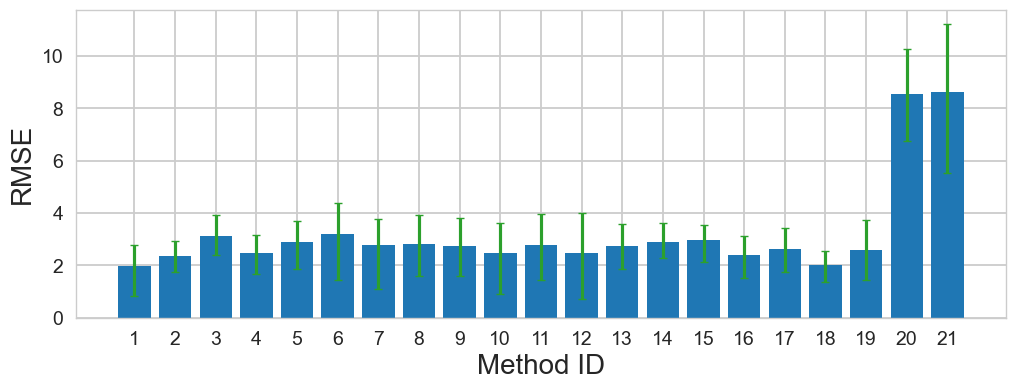

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_6334/491750911.py:205: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn-talk", "seaborn-whitegrid"])
/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_6334/491750911.py:205: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn-talk", "seaborn-whitegrid"])


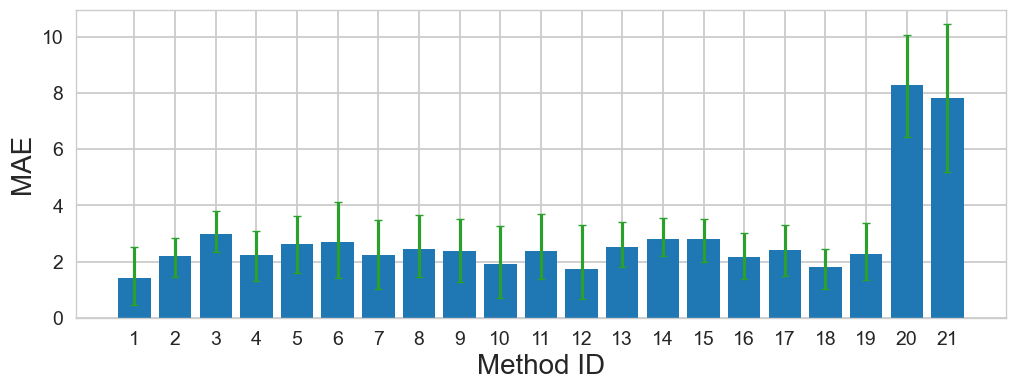

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_6334/491750911.py:205: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn-talk", "seaborn-whitegrid"])
/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_6334/491750911.py:205: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn-talk", "seaborn-whitegrid"])


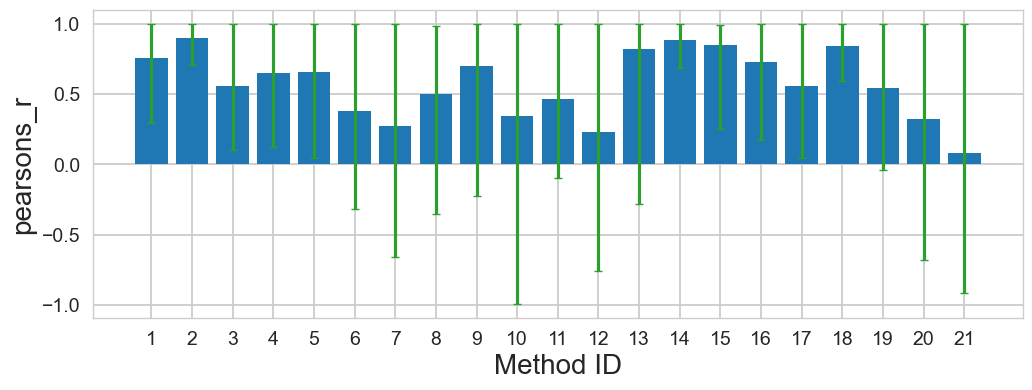

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_6334/491750911.py:205: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn-talk", "seaborn-whitegrid"])
/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_6334/491750911.py:205: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn-talk", "seaborn-whitegrid"])


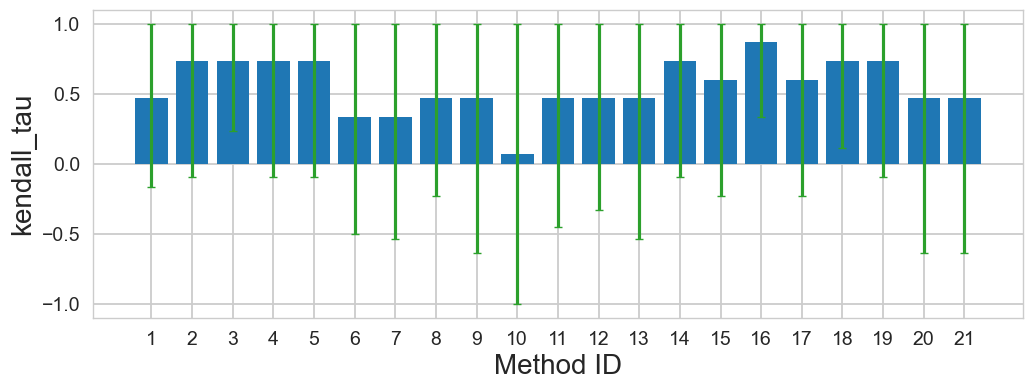

/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_6334/491750911.py:205: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn-talk", "seaborn-whitegrid"])
/var/folders/m4/nnk97_657qjdjyb37tkc3tv80000gn/T/ipykernel_6334/491750911.py:205: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn-talk", "seaborn-whitegrid"])


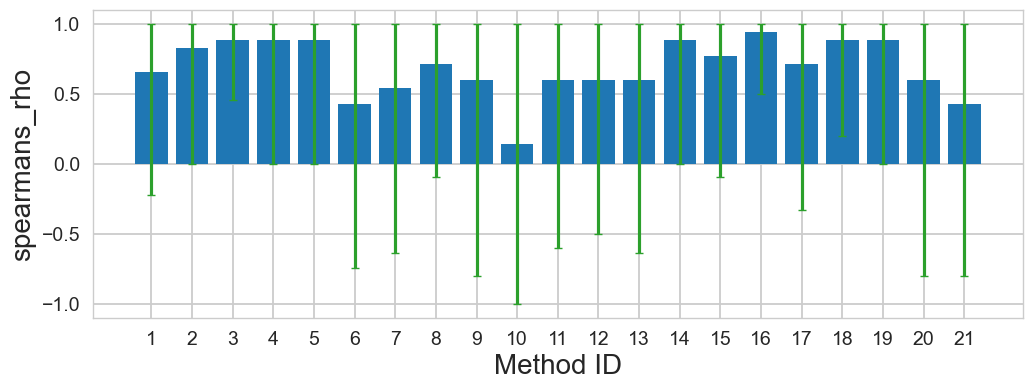

In [10]:

barplot_with_CI_errorbars(df=statistics_csv, x_label='Method ID', y_label='RMSE', y_lower_label='RMSE_lower_bound', y_upper_label='RMSE_upper_bound', figsize=(12,4))
plt.yticks(fontsize=14)
plt.savefig(DIRECTORY_PATH + "/RMSE_vs_condition_id_plot.pdf")
plt.show()

barplot_with_CI_errorbars(df=statistics_csv, x_label='Method ID', y_label='MAE', y_lower_label='MAE_lower_bound', y_upper_label='MAE_upper_bound', figsize=(12,4))
plt.yticks(fontsize=14)
plt.savefig(DIRECTORY_PATH + "/MAE_vs_condition_id_plot.pdf")
plt.show()

barplot_with_CI_errorbars(df=statistics_csv, x_label='Method ID', y_label='pearsons_r', y_lower_label='pearsons_r_lower_bound', y_upper_label='pearsons_r_upper_bound', figsize=(12,4))
plt.yticks(fontsize=14)
plt.savefig(DIRECTORY_PATH + "/pearsons_r_vs_condition_id_plot.pdf")
plt.show()

barplot_with_CI_errorbars(df=statistics_csv, x_label='Method ID', y_label='kendall_tau', y_lower_label='kendall_tau_lower_bound', y_upper_label='kendall_tau_upper_bound', figsize=(12,4))
plt.yticks(fontsize=14)
plt.savefig(DIRECTORY_PATH + "/kendalls_tau_vs_condition_id_plot.pdf")
plt.show()

barplot_with_CI_errorbars(df=statistics_csv, x_label='Method ID', y_label='spearmans_rho', y_lower_label='spearmans_rho_lower_bound', y_upper_label='spearmans_rho_upper_bound', figsize=(12,4))
plt.yticks(fontsize=14)
plt.savefig(DIRECTORY_PATH + "/spearmans_rho_vs_condition_id_plot.pdf")
plt.show()